In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# For JApanese dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GenAIproject/parsed_legal_qa_trainenglish.csv")

# Split into 80% train and 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

In [ ]:
from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 10:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Count trainable vs total parameters
trainable = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in embedding_model.parameters())
print(f"Trainable: {trainable} / Total: {total}")


Trainable: 38603520 / Total: 109482240


In [ ]:
# Access the Hugging Face model inside the SentenceTransformers wrapper
hf_model = word_embedding_model.auto_model

# Print hidden size and number of layers
print("Hidden size:", hf_model.config.hidden_size)
print("Number of transformer layers:", hf_model.config.num_hidden_layers)

# List all transformer layers
for i, layer in enumerate(hf_model.encoder.layer):
    print(f"Layer {i}: {layer}")


Hidden size: 768
Number of transformer layers: 12
Layer 0: BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
Layer 1: BertLayer

In [ ]:
from sentence_transformers import losses

train_loss = losses.CosineSimilarityLoss(model=embedding_model)


In [ ]:
pip install datasets

In [ ]:
from sentence_transformers import InputExample
from datasets import IterableDataset
from sentence_transformers import InputExample, SentencesDataset
from datasets import Dataset
# Step 1: Clean and preprocess the data
train_df = train_df.dropna(subset=["article", "query", "label"])
train_df['label'] = train_df['label'].map({'Y': 1, 'N': 0})

# Step 2: Create InputExample objects for the Sentence-Transformers Trainer
train_examples = [
    InputExample(texts=[row['query'], row['article']], label=float(row['label']))
    for _, row in train_df.iterrows()
]


# Step 2: Convert data to the correct Hugging Face Dataset format with separate columns for query and article
hf_dataset = Dataset.from_dict({
    "query": train_df["query"].tolist(),
    "article": train_df["article"].tolist(),
    "label": train_df["label"].tolist()
})


# Now, train_dataset is iterable and you can pass it to your trainer


In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import accuracy_score, f1_score

# For example, label might already be in a "Yes"/"No" format, so just encode it
val_labels = [1 if label == 'Y' else 0 for label in val_df["label"]]

# Create the ClassificationEvaluator
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_df["query"],   # Use the 'query' as sentence1
    sentences2=val_df["article"], # Use the 'article' as sentence2
    scores=val_labels,
    main_similarity="cosine"
)

In [ ]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
 # Define the training arguments
args = SentenceTransformerTrainingArguments(
output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers",
num_train_epochs=1,
per_device_train_batch_size=4,
per_device_eval_batch_size=4,
warmup_steps=100,
fp16=True,
eval_steps=100,
logging_steps=100,
report_to="none"
)

In [ ]:
!pip install -U "sentence-transformers[train]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
# 10. Start training
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
pip install wandb

In [ ]:
from sentence_transformers.trainer import SentenceTransformerTrainer
 # Train embedding model
trainer = SentenceTransformerTrainer(
 model=embedding_model,
 args=args,
 train_dataset=hf_dataset,
 loss=train_loss,
 evaluator=evaluator
 )
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
100,0.314500
200,0.264800


TrainOutput(global_step=240, training_loss=0.2838848471641541, metrics={'train_runtime': 2077.6933, 'train_samples_per_second': 0.462, 'train_steps_per_second': 0.116, 'total_flos': 0.0, 'train_loss': 0.2838848471641541, 'epoch': 1.0})

In [ ]:
# loading the saved model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers/checkpoint-240")

In [ ]:
# Show the first 10 rows of the raw validation data
print(val_df[["query", "article", "label"]].head(10))

# Optionally, check unique label values to see what exactly is present
print("Unique label values in val_df:", val_df["label"].unique())


                                                  query  \
276   In a contract that involves the completion of ...   
800   When the due date of the claim that is the obj...   
226   When a debtor who is solely responsible for mo...   
1088  In a lawsuit in which an agent claims the paym...   
1149  Concurrent debt assumption shall be validly es...   
666   The validity of a contract for the benefit of ...   
1170  A has concluded a loan contract with B to allo...   
549   When a defect in the object of work was caused...   
674   The administrator appointed by the absentee ma...   
0     A special agreement exempting the seller from ...   

                                                article label  
276   Article 637: In the case prescribed in the mai...     N  
800   Article 366: A pledgee may directly collect th...     N  
226   Article 147: In the event of any of the follow...     N  
1088  Article 632: A contract comes into effect when...     N  
1149  Article 470: The assumer

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Ensure the DataFrame index is reset (to avoid KeyError issues)
val_df = val_df.reset_index(drop=True)
val_df['label'] = val_df['label'].map({'Y': 1, 'N': 0})
# Convert labels to float list (if already numeric 0/1)
val_labels = val_df["label"].astype(float).tolist()

# Ensure sentences are passed as lists of strings
queries = val_df["query"].astype(str).tolist()
articles = val_df["article"].astype(str).tolist()

# Create the evaluator
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=queries,       # Hypotheses
    sentences2=articles,     # Articles
    scores=val_labels,       # Ground-truth entailment (1 or 0)
    main_similarity="cosine" # Similarity metric
)
import pandas as pd

val_display_df = pd.DataFrame({
    "query": queries,
    "article": articles,
    "label": val_labels
})

# Show the first few rows
print(val_display_df.head(10))

                                               query  \
0  In a contract that involves the completion of ...   
1  When the due date of the claim that is the obj...   
2  When a debtor who is solely responsible for mo...   
3  In a lawsuit in which an agent claims the paym...   
4  Concurrent debt assumption shall be validly es...   
5  The validity of a contract for the benefit of ...   
6  A has concluded a loan contract with B to allo...   
7  When a defect in the object of work was caused...   
8  The administrator appointed by the absentee ma...   
9  A special agreement exempting the seller from ...   

                                             article  label  
0  Article 637: In the case prescribed in the mai...    0.0  
1  Article 366: A pledgee may directly collect th...    0.0  
2  Article 147: In the event of any of the follow...    0.0  
3  Article 632: A contract comes into effect when...    0.0  
4  Article 470: The assumer of a concurrent debt ...    1.0  
5  (Contrac

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.1482114054900538, 'spearman_cosine': 0.13365225517837898}

**For the 2nd epoch**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

# Step 1: Load model from checkpoint
embedding_model = SentenceTransformer("/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers/checkpoint-240")

# Step 2: Freeze top layers again
# Access the HuggingFace model inside the wrapper
transformer_model = embedding_model[0].auto_model  # [0] gives the Transformer() module

# Freeze top N layers (e.g., top 10)
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 10:
        for param in layer.parameters():
            param.requires_grad = False

# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")



Trainable parameters: 38603520


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train(resume_from_checkpoint=True)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
300,0.235900,No log,0.205526,0.193080
400,0.227600,No log,0.183496,0.165050


TrainOutput(global_step=480, training_loss=0.11476437250773112, metrics={'train_runtime': 2378.0373, 'train_samples_per_second': 0.807, 'train_steps_per_second': 0.202, 'total_flos': 0.0, 'train_loss': 0.11476437250773112, 'epoch': 2.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.19192930646173115, 'spearman_cosine': 0.18092978558801256}

**For the 3rd epoch**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

# Step 1: Load model from checkpoint
embedding_model = SentenceTransformer("/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers/checkpoint-480")

# Step 2: Freeze top layers again
# Access the HuggingFace model inside the wrapper
transformer_model = embedding_model[0].auto_model  # [0] gives the Transformer() module

# Freeze top N layers (e.g., top 10)
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 10:
        for param in layer.parameters():
            param.requires_grad = False

# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")



Trainable parameters: 38603520


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train(resume_from_checkpoint=True)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
500,0.210500,No log,0.204455,0.195366
600,0.207000,No log,0.208884,0.201621
700,0.202800,No log,0.210544,0.209681


TrainOutput(global_step=720, training_loss=0.06859280599488152, metrics={'train_runtime': 2474.5078, 'train_samples_per_second': 1.164, 'train_steps_per_second': 0.291, 'total_flos': 0.0, 'train_loss': 0.06859280599488152, 'epoch': 3.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.21131873552106425, 'spearman_cosine': 0.21004215800310502}

**For few more epochs**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

# Step 1: Load model from checkpoint
embedding_model = SentenceTransformer("/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers/checkpoint-720")

# Step 2: Freeze top layers again
# Access the HuggingFace model inside the wrapper
transformer_model = embedding_model[0].auto_model  # [0] gives the Transformer() module

# Freeze top N layers (e.g., top 10)
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 10:
        for param in layer.parameters():
            param.requires_grad = False

# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")



Trainable parameters: 38603520


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers",
    num_train_epochs=6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train(resume_from_checkpoint=True)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Didn't manage to set back the RNG states of the CUDA because of the following error:
 'cuda'
This won't yield the same results as if the training had not been interrupted.


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
800,0.196800,No log,0.216473,0.216659
900,0.194800,No log,0.244721,0.243606
1000,0.188100,No log,0.229413,0.224839
1100,0.160300,No log,0.213628,0.203546
1200,0.161100,No log,0.208965,0.200178
1300,0.133600,No log,0.212437,0.203787
1400,0.143100,No log,0.207013,0.197411


TrainOutput(global_step=1440, training_loss=0.08254724542299906, metrics={'train_runtime': 86.7623, 'train_samples_per_second': 66.388, 'train_steps_per_second': 16.597, 'total_flos': 0.0, 'train_loss': 0.08254724542299906, 'epoch': 6.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.20656883522039177, 'spearman_cosine': 0.19729045768905626}

**For few more epochs**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

# Step 1: Load model from checkpoint
embedding_model = SentenceTransformer("/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers/checkpoint-1440")

# Step 2: Freeze top layers again
# Access the HuggingFace model inside the wrapper
transformer_model = embedding_model[0].auto_model  # [0] gives the Transformer() module

# Freeze top N layers (e.g., top 10)
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 10:
        for param in layer.parameters():
            param.requires_grad = False

# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")



Trainable parameters: 38603520


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train(resume_from_checkpoint=True)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1500,0.125700,No log,0.195349,0.184659
1600,0.131800,No log,0.186672,0.180809
1700,0.130800,No log,0.196737,0.181291
1800,0.118300,No log,0.166298,0.146404
1900,0.108300,No log,0.161015,0.140269
2000,0.104800,No log,0.175136,0.155065
2100,0.098400,No log,0.169106,0.150254
2200,0.104500,No log,0.163701,0.143517
2300,0.082800,No log,0.166145,0.147366
2400,0.089700,No log,0.167933,0.149171


TrainOutput(global_step=2400, training_loss=0.043531359632809956, metrics={'train_runtime': 118.2525, 'train_samples_per_second': 81.182, 'train_steps_per_second': 20.296, 'total_flos': 0.0, 'train_loss': 0.043531359632809956, 'epoch': 10.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.1679334667016025, 'spearman_cosine': 0.14917083386245716}

**With three layers freezed**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 9:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 45691392


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers9",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.303700,No log,0.071263,0.057503
200,0.278600,No log,0.181364,0.165772
300,0.238000,No log,0.177398,0.164569
400,0.219900,No log,0.260963,0.260087
500,0.211800,No log,0.253456,0.238914
600,0.150900,No log,0.191000,0.192358
700,0.161100,No log,0.244552,0.257079
800,0.124800,No log,0.225236,0.228809
900,0.115400,No log,0.244036,0.251064
1000,0.098600,No log,0.233183,0.245891


TrainOutput(global_step=2400, training_loss=0.10237838620940844, metrics={'train_runtime': 311.8287, 'train_samples_per_second': 30.786, 'train_steps_per_second': 7.697, 'total_flos': 0.0, 'train_loss': 0.10237838620940844, 'epoch': 10.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.257688173196595, 'spearman_cosine': 0.2600865667827681}

**With four unfreezed layers**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 8:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 52779264


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.298700,No log,0.060610,0.048360
200,0.277800,No log,0.238615,0.248538
300,0.242400,No log,0.151825,0.146645
400,0.225900,No log,0.231434,0.224598
500,0.222600,No log,0.245212,0.235305
600,0.153500,No log,0.244567,0.228328
700,0.165800,No log,0.232812,0.237109
800,0.119800,No log,0.264205,0.267305
900,0.107900,No log,0.247644,0.256478
1000,0.090000,No log,0.262539,0.268508


TrainOutput(global_step=2400, training_loss=0.09553296742339928, metrics={'train_runtime': 331.9368, 'train_samples_per_second': 28.921, 'train_steps_per_second': 7.23, 'total_flos': 0.0, 'train_loss': 0.09553296742339928, 'epoch': 10.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.3057553529101815, 'spearman_cosine': 0.3036348263458402}

**With five layers unfreezed**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 7:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 59867136


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers7",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.297100,No log,0.035742,0.027669
200,0.280100,No log,0.132696,0.147126
300,0.243800,No log,0.118350,0.095517
400,0.222200,No log,0.207138,0.195125
500,0.220400,No log,0.166612,0.157231
600,0.141900,No log,0.216485,0.202102
700,0.156000,No log,0.202102,0.209561
800,0.105700,No log,0.219543,0.220628
900,0.098100,No log,0.181539,0.177802
1000,0.075200,No log,0.204336,0.208478


TrainOutput(global_step=2400, training_loss=0.08883537898461023, metrics={'train_runtime': 342.2117, 'train_samples_per_second': 28.053, 'train_steps_per_second': 7.013, 'total_flos': 0.0, 'train_loss': 0.08883537898461023, 'epoch': 10.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.22651524770223058, 'spearman_cosine': 0.22483894232978424}

**With 6 layers unfreezed**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 6:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 66955008


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers6",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.295500,No log,0.017937,0.010947
200,0.280700,No log,0.175297,0.148329
300,0.247400,No log,0.154588,0.131126
400,0.235800,No log,0.254896,0.250703
500,0.228100,No log,0.233593,0.221591
600,0.149400,No log,0.270446,0.253831
700,0.169100,No log,0.252250,0.247215
800,0.117200,No log,0.242490,0.244087
900,0.101500,No log,0.234536,0.234102
1000,0.078300,No log,0.234447,0.234824


TrainOutput(global_step=2400, training_loss=0.09089787095785141, metrics={'train_runtime': 358.1884, 'train_samples_per_second': 26.802, 'train_steps_per_second': 6.7, 'total_flos': 0.0, 'train_loss': 0.09089787095785141, 'epoch': 10.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.2360522803309073, 'spearman_cosine': 0.23747034358426652}

# **Plotting the graphs to chose the best performance**

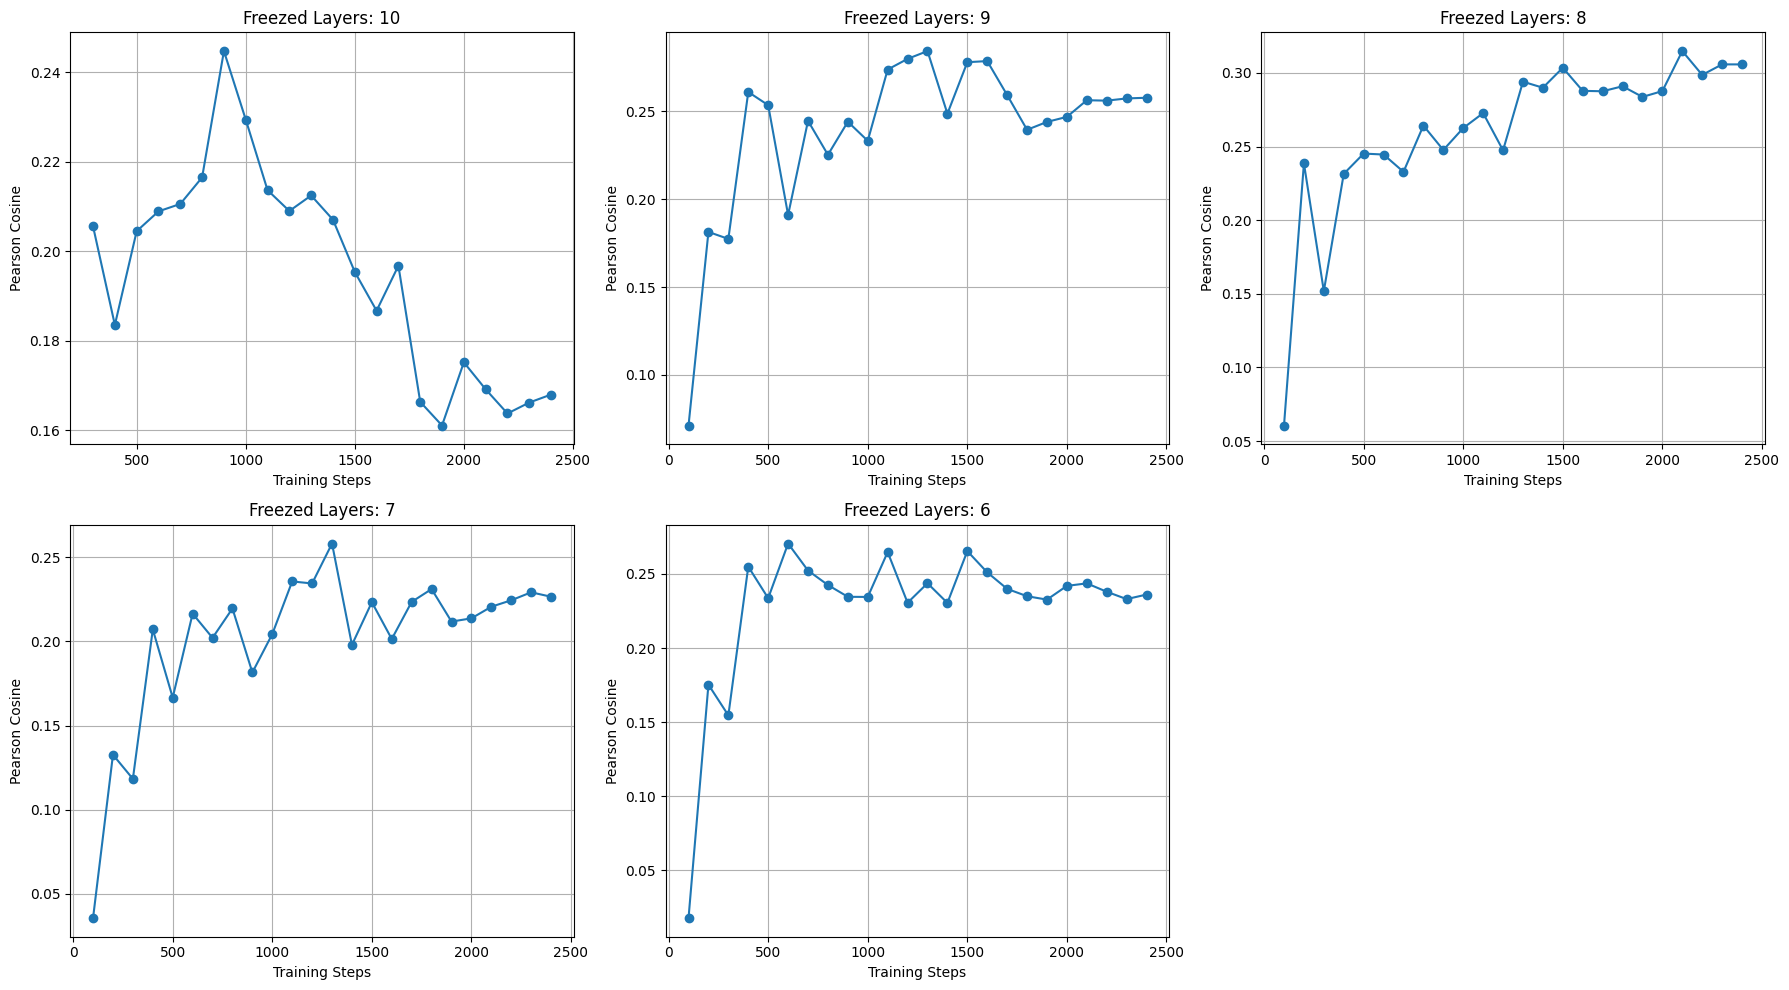

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Folder suffixes
suffixes = ["", "9", "8", "7", "6"]
base_path = "/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers"

# Set up 2 rows x 3 columns subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, s in enumerate(suffixes):
    try:
        folder = f"{base_path}{s}"
        file_path = f"{folder}/eval/similarity_evaluation_results.csv"
        df = pd.read_csv(file_path)

        axes[i].plot(df['steps'], df['cosine_pearson'], marker='o')
        axes[i].set_title(f"Freezed Layers: {s if s else '10'}")
        axes[i].set_xlabel("Training Steps")
        axes[i].set_ylabel("Pearson Cosine")
        axes[i].grid(True)
    except Exception as e:
        print(f"Failed to plot for {s}: {e}")
        axes[i].set_visible(False)

# Hide the unused subplot (last cell if only 5 plots)
if len(suffixes) < len(axes):
    for j in range(len(suffixes), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Trying deleting the top 6 layers instead

In [ ]:
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import losses
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.trainer import SentenceTransformerTrainer

# Load the pretrained BERT model
model_name = "nlpaueb/legal-bert-base-uncased"
transformer_model = BertModel.from_pretrained(model_name)

# Define the number of layers you want to keep
layers_to_keep = 6  # Keep only the first 6 layers

# Manually modify the model to keep only the desired number of layers
transformer_model.encoder.layer = transformer_model.encoder.layer[:layers_to_keep]

# Load the tokenizer (needed for SentenceTransformer)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Create a custom word embedding model by passing the modified transformer_model directly
word_embedding_model = models.Transformer(
    model_name=model_name,  # Use the model name to load the pre-trained tokenizer and config
    max_seq_length=512
)

# Add pooling layer (mean pooling)
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Combine into the SentenceTransformer model
embedding_model = SentenceTransformer(modules=[
    word_embedding_model,
    pooling_model
])


TypeError: Transformer.__init__() got an unexpected keyword argument 'model_name'

In [ ]:
# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers6",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
    eval_strategy="steps",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none"
)

# Define the loss function
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,  # replace with your actual dataset
    loss=train_loss,
    evaluator=evaluator  # replace with your actual evaluator
)

# Train the model
trainer.train()


**Not Wrking with Drop Out**

In [ ]:
from sentence_transformers import SentenceTransformer, models, losses
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
import torch
from torch import nn
import os
import json

# -----------------------------
# Step 0: Define DropoutDense Module with Save/Load
# -----------------------------
class DropoutDense(nn.Module):
    def __init__(self, input_dim, output_dim=256, dropout_prob=0.3):
        super(DropoutDense, self).__init__()
        self.config_keys = ['input_dim', 'output_dim', 'dropout_prob']
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob

        self.dropout = nn.Dropout(dropout_prob)
        self.dense = nn.Linear(input_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, features):
        x = features['sentence_embedding']
        x = self.dropout(x)
        x = self.dense(x)
        x = self.activation(x)
        features['sentence_embedding'] = x
        return features

    def save(self, output_path):
        os.makedirs(output_path, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(output_path, 'pytorch_model.bin'))
        with open(os.path.join(output_path, 'config.json'), 'w') as f:
            json.dump({key: getattr(self, key) for key in self.config_keys}, f)

    @staticmethod
    def load(input_path):
        with open(os.path.join(input_path, 'config.json')) as f:
            config = json.load(f)
        model = DropoutDense(**config)
        model.load_state_dict(torch.load(os.path.join(input_path, 'pytorch_model.bin'), map_location='cpu'))
        return model

# -----------------------------
# Step 1: Load Transformer Model
# -----------------------------
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 8 BERT layers
transformer_model = word_embedding_model.auto_model
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 8:
        for param in layer.parameters():
            param.requires_grad = False

# -----------------------------
# Step 2: Pooling Layer
# -----------------------------
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# -----------------------------
# Step 3: Add Custom DropoutDense Layer
# -----------------------------
dropout_dense_model = DropoutDense(
    input_dim=pooling_model.get_sentence_embedding_dimension(),
    output_dim=256,
    dropout_prob=0.1
)

# -----------------------------
# Step 4: Build SentenceTransformer Model
# -----------------------------
embedding_model = SentenceTransformer(modules=[
    word_embedding_model,
    pooling_model,
    dropout_dense_model
])

# Optional: Check trainable parameters
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# -----------------------------
# Step 5: Training Arguments
# -----------------------------
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8_dropout1",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    weight_decay=0.001,  # Helps reduce overfitting
    eval_steps=100,
    logging_steps=100,
    eval_strategy="steps",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none"  # Avoids deprecated WANDB env var warning
)

# -----------------------------
# Step 6: Define Loss and Trainer
# -----------------------------
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,   # ✅ replace with your actual dataset
    loss=train_loss,
    evaluator=evaluator         # ✅ replace with your actual evaluator
)

# -----------------------------
# Step 7: Train the Model
# -----------------------------
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Trainable parameters: 52976128


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.298700,No log,0.021440,0.032000
200,0.288300,No log,0.114384,0.111998
300,0.245400,No log,0.175403,0.190915
400,0.227500,No log,0.152972,0.173952
500,0.228200,No log,0.198337,0.218463
600,0.151900,No log,0.154604,0.141833
700,0.164100,No log,0.197444,0.227365
800,0.128300,No log,0.213962,0.203907
900,0.115900,No log,0.148186,0.150374
1000,0.100100,No log,0.154800,0.147727


TrainOutput(global_step=4800, training_loss=0.05218626994484415, metrics={'train_runtime': 674.2129, 'train_samples_per_second': 28.478, 'train_steps_per_second': 7.119, 'total_flos': 0.0, 'train_loss': 0.05218626994484415, 'epoch': 20.0})

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

# Step 1: Load model from checkpoint
embedding_model = SentenceTransformer("/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8/checkpoint-2400")

# Step 2: Freeze top layers again
# Access the HuggingFace model inside the wrapper
transformer_model = embedding_model[0].auto_model  # [0] gives the Transformer() module

# Freeze top N layers (e.g., top 10)
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 8:
        for param in layer.parameters():
            param.requires_grad = False

# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")



Trainable parameters: 52779264


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train(resume_from_checkpoint=True)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
2500,0.011800,No log,0.259388,0.255636
2600,0.011200,No log,0.273418,0.275485
2700,0.013300,No log,0.201895,0.192118
2800,0.012500,No log,0.287798,0.286673
2900,0.010200,No log,0.267416,0.268748
3000,0.008500,No log,0.253624,0.262974
3100,0.009600,No log,0.278506,0.272237
3200,0.008600,No log,0.294195,0.286312
3300,0.005500,No log,0.260041,0.237230
3400,0.005900,No log,0.290388,0.266703


TrainOutput(global_step=4800, training_loss=0.0028434094414114953, metrics={'train_runtime': 330.3573, 'train_samples_per_second': 58.119, 'train_steps_per_second': 14.53, 'total_flos': 0.0, 'train_loss': 0.0028434094414114953, 'epoch': 20.0})

In [ ]:
# ✅ Step 1: Define the model (fresh, same as before)
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")
transformer_model = word_embedding_model.auto_model
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 8:
        for param in layer.parameters():
            param.requires_grad = False

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# ✅ Step 2: Set training args
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
    eval_strategy="steps",
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"
)

# ✅ Step 3: Loss
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# ✅ Step 4: Trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# ✅ Step 5: Resume correctly from checkpoint (model + optimizer + scheduler)
trainer.train(resume_from_checkpoint="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8/checkpoint-2400")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
2500,0.011800,No log,0.259318,0.256357
2600,0.011100,No log,0.274642,0.277049
2700,0.013600,No log,0.197483,0.192599
2800,0.012500,No log,0.283446,0.281740
2900,0.010200,No log,0.258207,0.261771
3000,0.008500,No log,0.253196,0.261891
3100,0.010200,No log,0.280554,0.274763
3200,0.008000,No log,0.285246,0.279094
3300,0.005600,No log,0.267369,0.242643
3400,0.006700,No log,0.287917,0.266222


TrainOutput(global_step=4800, training_loss=0.0028325569878021877, metrics={'train_runtime': 400.2965, 'train_samples_per_second': 47.964, 'train_steps_per_second': 11.991, 'total_flos': 0.0, 'train_loss': 0.0028325569878021877, 'epoch': 20.0})

**Again retraining the model with 8 freezed layers for 20 epochs**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 8:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 52779264


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8_20",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.298700,No log,0.058197,0.046796
200,0.278200,No log,0.156669,0.155547
300,0.235600,No log,0.074838,0.055338
400,0.222800,No log,0.187253,0.163847
500,0.215400,No log,0.243022,0.246012
600,0.150800,No log,0.189477,0.190554
700,0.161800,No log,0.185920,0.211606
800,0.115100,No log,0.196594,0.204749
900,0.107800,No log,0.197798,0.209080
1000,0.088900,No log,0.179730,0.186343


TrainOutput(global_step=4800, training_loss=0.04813989415920029, metrics={'train_runtime': 683.1312, 'train_samples_per_second': 28.106, 'train_steps_per_second': 7.026, 'total_flos': 0.0, 'train_loss': 0.04813989415920029, 'epoch': 20.0})

**Issue with resuming training from 10 epochs**

Step 100: Learning Rate = 4.9500000000000004e-05
Step 200: Learning Rate = 4.784782608695653e-05
Step 300: Learning Rate = 4.569565217391305e-05
Step 400: Learning Rate = 4.352173913043479e-05
Step 500: Learning Rate = 4.1347826086956526e-05
Step 600: Learning Rate = 3.917391304347826e-05
Step 700: Learning Rate = 3.7e-05
Step 800: Learning Rate = 3.4826086956521744e-05
Step 900: Learning Rate = 3.2652173913043484e-05
Step 1000: Learning Rate = 3.0478260869565216e-05
Step 1100: Learning Rate = 2.830434782608696e-05
Step 1200: Learning Rate = 2.6130434782608698e-05
Step 1300: Learning Rate = 2.3956521739130437e-05
Step 1400: Learning Rate = 2.1782608695652177e-05
Step 1500: Learning Rate = 1.9608695652173913e-05
Step 1600: Learning Rate = 1.7434782608695652e-05
Step 1700: Learning Rate = 1.526086956521739e-05
Step 1800: Learning Rate = 1.308695652173913e-05
Step 1900: Learning Rate = 1.091304347826087e-05
Step 2000: Learning Rate = 8.73913043478261e-06
Step 2100: Learning Rate = 6.56521

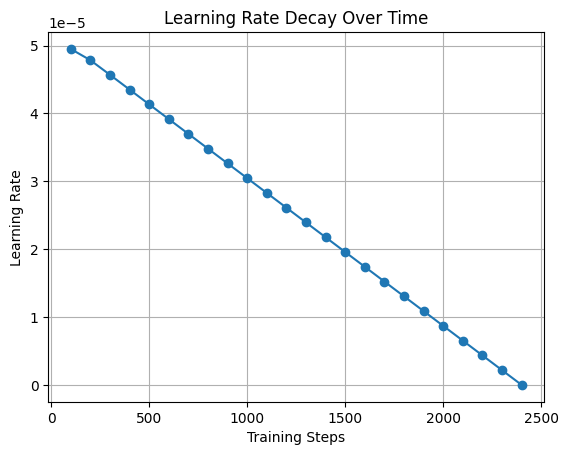

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to your trainer state log
trainer_state_path = "/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8/checkpoint-2400/trainer_state.json"

# Load the trainer state file
with open(trainer_state_path, "r") as f:
    trainer_state = json.load(f)

# Extract learning rate and steps
steps = []
learning_rates = []

for entry in trainer_state["log_history"]:
    if "step" in entry and "learning_rate" in entry:
        steps.append(entry["step"])
        learning_rates.append(entry["learning_rate"])
        print(f"Step {entry['step']}: Learning Rate = {entry['learning_rate']}")

# Plot the learning rate trend
plt.plot(steps, learning_rates, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Decay Over Time")
plt.grid(True)
plt.show()


Step 100: Learning Rate = 4.9500000000000004e-05
Step 200: Learning Rate = 4.784782608695653e-05
Step 300: Learning Rate = 4.569565217391305e-05
Step 400: Learning Rate = 4.352173913043479e-05
Step 500: Learning Rate = 4.1347826086956526e-05
Step 600: Learning Rate = 3.917391304347826e-05
Step 700: Learning Rate = 3.7e-05
Step 800: Learning Rate = 3.4826086956521744e-05
Step 900: Learning Rate = 3.2652173913043484e-05
Step 1000: Learning Rate = 3.0478260869565216e-05
Step 1100: Learning Rate = 2.830434782608696e-05
Step 1200: Learning Rate = 2.6130434782608698e-05
Step 1300: Learning Rate = 2.3956521739130437e-05
Step 1400: Learning Rate = 2.1782608695652177e-05
Step 1500: Learning Rate = 1.9608695652173913e-05
Step 1600: Learning Rate = 1.7434782608695652e-05
Step 1700: Learning Rate = 1.526086956521739e-05
Step 1800: Learning Rate = 1.308695652173913e-05
Step 1900: Learning Rate = 1.091304347826087e-05
Step 2000: Learning Rate = 8.73913043478261e-06
Step 2100: Learning Rate = 6.56521

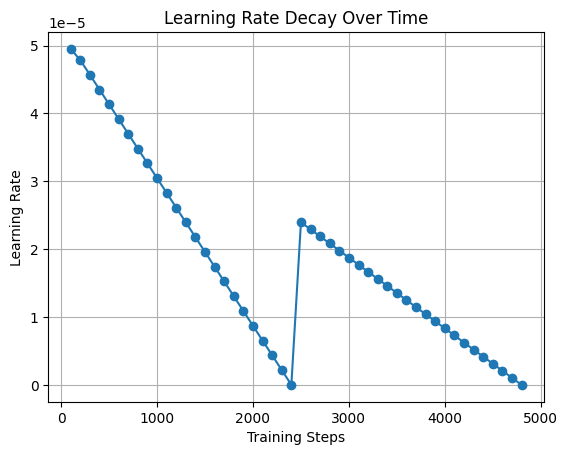

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to your trainer state log
trainer_state_path = "/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_model_freezed_layers8/checkpoint-4800/trainer_state.json"

# Load the trainer state file
with open(trainer_state_path, "r") as f:
    trainer_state = json.load(f)

# Extract learning rate and steps
steps = []
learning_rates = []

for entry in trainer_state["log_history"]:
    if "step" in entry and "learning_rate" in entry:
        steps.append(entry["step"])
        learning_rates.append(entry["learning_rate"])
        print(f"Step {entry['step']}: Learning Rate = {entry['learning_rate']}")

# Plot the learning rate trend
plt.plot(steps, learning_rates, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Decay Over Time")
plt.grid(True)
plt.show()
